<a href="https://colab.research.google.com/github/Hardik-Damor/Customer_Segmentation_using_ML/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Exploratory Data Analysis
Import the libraries

In [1]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler

# PCA from Scikit-Learn
from sklearn.decomposition import PCA

# Scikit-Learn's KMeans algorithm
from sklearn.cluster import KMeans

# Adjusted Rand index
from sklearn.metrics import adjusted_rand_score

## Load the dataset

In [3]:
from google.colab import files
uploaded = files.upload()

Saving transactions_data.csv to transactions_data.csv


In [4]:
# Load international online transactions data from CSV
df = pd.read_csv('transactions_data.csv')

In [5]:
#Dataframe dimension
df.shape

(35116, 8)

In [6]:
# First 10 rows of data
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583.0,France
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583.0,France
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583.0,France
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583.0,France
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583.0,France


<Axes: xlabel='count', ylabel='Country'>

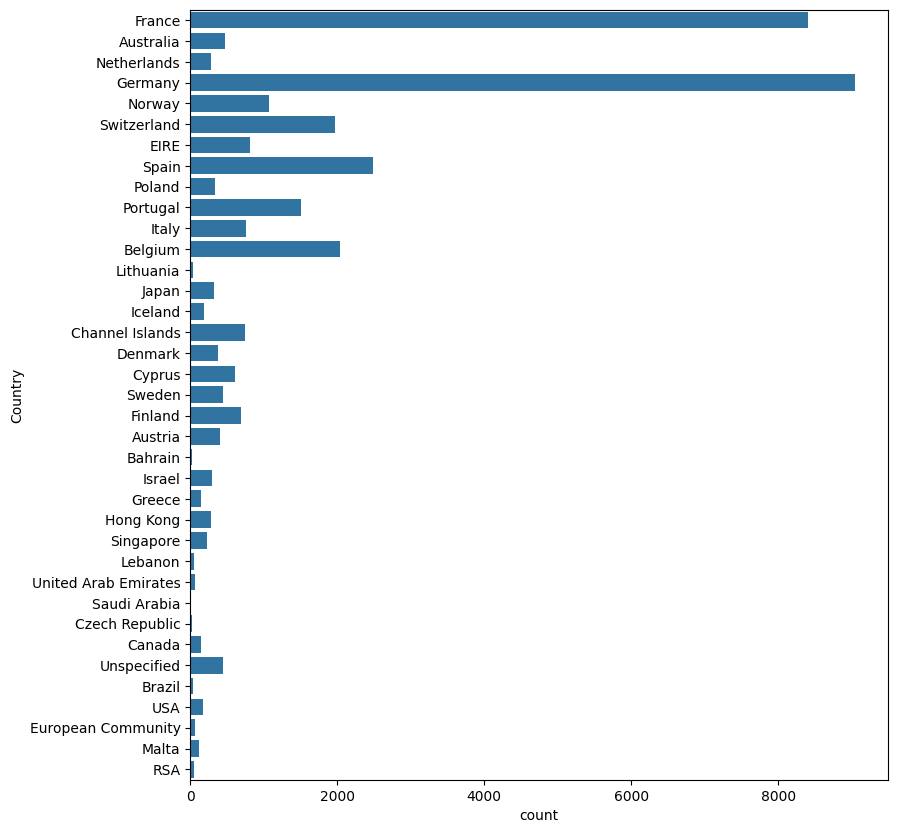

In [7]:
# Make figsize
plt.figure(figsize=(9,10))

# Bar plot by country
sns.countplot(y='Country', data=df)

# Transaction-level Cleaning


In [8]:
# Missing data by feature
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,1418
Country,0


In [9]:
# Only keep transactions with CustomerID's
df = df[df.CustomerID.notnull()]

In [10]:
# Convert customer ID's into integers
df['CustomerID'] = df.CustomerID.astype(int)

# Display first 5 CustomerID's in the transaction dataset
df.CustomerID.head()

,CustomerID
0,12583
1,12583
2,12583
3,12583
4,12583


In [11]:
# Create 'Sales' interaction feature
df['Sales'] = df.Quantity * df.UnitPrice

# Display first 5 Sales values in the transaction dataset
df.Sales.head()

,Sales
0,90.0
1,90.0
2,45.0
3,10.2
4,15.6


Before moving on, save your cleaned transaction-level data as **cleaned_transactions.csv.**

In [12]:
# Save cleaned transaction-level data
df.to_csv('cleaned_transactions.csv', index=None)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583,France,90.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583,France,90.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583,France,45.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583,France,10.2
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583,France,15.6


# Customer-level feature engineering


In [13]:
# Aggegrate invoice data
invoice_data = df.groupby('CustomerID').agg(total_transactions=('InvoiceNo', 'nunique'))


# Display invoice data for first 5 customers
invoice_data.head()

,total_transactions
CustomerID,
12347,7
12348,4
12349,1
12350,1
12352,8


In [14]:
product_data = df.groupby('CustomerID').agg(
    total_products=('StockCode', 'count'),
    total_unique_products=('StockCode', 'nunique')
)

# Display the aggregated data for the first 5 customers
print(product_data.head())

            total_products  total_unique_products
CustomerID                                       
12347                  182                    103
12348                   31                     22
12349                   73                     73
12350                   17                     17
12352                   85                     59


In [16]:
# Roll up sales data
sales_data = df.groupby('CustomerID').Sales.agg(
    total_sales='sum',
    avg_product_value='mean'
)

# Display sales data for first 5 customers
sales_data.head()

,total_sales,avg_product_value
CustomerID,,
12347,4310.00,23.681319
12348,1797.24,57.975484
12349,1757.55,24.076027
12350,334.40,19.670588
12352,2506.04,29.482824


# Intermediary levels


In [18]:
# Aggregate cart-level data (i.e. invoice-level)
cart_data = df.groupby(['CustomerID', 'InvoiceNo']).Sales.agg(
    cart_value='sum'
)


# Display cart data for first 20 CARTS
cart_data.head(20)

cart_value
CustomerID InvoiceNo            
12347      537626         711.79
           542237         475.39
           549222         636.25
           556201         382.52
           562032         584.91
           573511        1294.32
           581180         224.82
12348      539318         892.80
           541998         227.44
           548955         367.00
           568172         310.00
12349      577609        1757.55
12350      543037         334.40
12352      544156         296.50
           545323         144.35
           545332         840.30
           546869         120.33
           547390         160.33
           567505         366.25
           568699         266.25

In [19]:
# Reset index
cart_data.reset_index(inplace=True)

# Display cart data for first 10 CARTS
cart_data.head(10)

,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91
5,12347,573511,1294.32
6,12347,581180,224.82
7,12348,539318,892.80
8,12348,541998,227.44
9,12348,548955,367.00


In [20]:
# Aggregate cart data (at customer-level)
agg_cart_data = cart_data.groupby('CustomerID').cart_value.agg( avg_cart_value = 'mean',
                                                                 min_cart_value = 'min',
                                                                 max_cart_value = 'max')

# Display cart data for first 5 CUSTOMERS
agg_cart_data.head()

,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
12347,615.714286,224.82,1294.32
12348,449.310000,227.44,892.80
12349,1757.550000,1757.55,1757.55
12350,334.400000,334.40,334.40
12352,313.255000,120.33,840.30


# Joining various customer level dataframes


In [21]:
# Join together customer-level data
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])

# Display customer-level data for first 5 customers
customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


In [22]:
# Save analytical base table
customer_df.to_csv('analytical_base_table.csv')

#Curse of Dimensionality.
Import the cleaned dataset (not the analytical base table) that we saved in previously.

In [23]:
# Read cleaned_transactions.csv
df = pd.read_csv('cleaned_transactions.csv')

In [24]:
# Get item_dummies - creates the vector of StockCode
item_dummies = pd.get_dummies(df.StockCode)

item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [25]:
# Add CustomerID to item_dummies
item_dummies['CustomerID'] = df.CustomerID

# Display first 5 rows of item_dummies
item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST,CustomerID
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,12583


Next, roll up the item dummies data into customer-level item data.

In [26]:
# Create item_data by aggregating at customer level
item_data = item_dummies.groupby('CustomerID').sum()

# Display first 5 rows of item_data
item_data.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5


Finally, let's display the total number times each item was purchased.

In [27]:
# Total times each item was purchased
item_data.sum()

,0
10002,12
10120,1
10125,13
10133,5
10135,4
...,...
90202D,1
90204,1
C2,6
M,34


In [28]:
# Save item_data.csv
item_data.to_csv('item_data.csv')

## Method 1 - Thresholding


In [29]:
# Display most popular 20 items
item_data.sum().sort_values().tail(120)

,0
22748,50
22847,50
15056BL,50
23159,50
85014B,50
...,...
22556,179
22554,197
22423,222
22326,271


In [30]:
# Get list of StockCodes for the 20 most popular items
top_20_items = item_data.sum().sort_values().tail(120).index

top_20_items

Index(['22748', '22847', '15056BL', '23159', '85014B', '23243', '23231',
       '22898', '23388', '23255',
       ...
       '21212', '22551', '22629', '22328', '21731', '22556', '22554', '22423',
       '22326', 'POST'],
      dtype='object', length=120)

Finally, we can keep only the features for those 20 items.

In [31]:
# Keep only features for top 20 items
top_20_item_data = item_data[top_20_items]

# Shape of remaining dataframe
top_20_item_data.shape

(414, 120)

In [32]:
top_20_item_data.head()

,22748,22847,15056BL,23159,85014B,23243,23231,22898,23388,23255,22966,22558,21558,22356,84997C,23292,22699,22331,22385,23480,84375,21156,21242,22417,21122,84997B,22895,22962,22557,22907,23307,20676,21977,21976,23293,22661,23290,22627,84879,20682,22367,23236,22355,22197,22553,20685,23108,22384,21936,20728,...,22631,22090,23199,21915,23203,84997D,22029,23209,23254,22077,22960,23256,22492,22467,22726,22382,23240,23245,21094,21086,23206,22352,22727,22138,22720,21559,22728,22555,20724,20712,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,2,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,5,0,0,0,3,0,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


In [33]:
# Save threshold_item_data.csv
top_20_item_data.to_csv('threshold_item_data.csv')

## PCA


In [35]:
# Read item_data.csv
item_data = pd.read_csv('item_data.csv', index_col=0)

In [36]:
# Display item_data's shape
item_data.shape

(414, 2574)

In [37]:
# Initialize instance of StandardScaler
scaler = StandardScaler()

# Fit and transform item_data
item_data_scaled = scaler.fit_transform(item_data)

# Display first 5 rows of item_data_scaled
item_data_scaled[:5]

array([[-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.68068072],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183,  0.38776219],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
         5.53128397,  0.65487292]])

In [38]:
# Initialize and fit a PCA transformation
pca = PCA()
pca.fit(item_data_scaled)

PCA()

Finally, generate new "principal component features" from item_data_scaled.

In [39]:
# Generate new features
PC_items = pca.transform(item_data_scaled)

# Display first 5 rows
PC_items[:5]

array([[ 5.87614052e+00,  4.82891689e+00, -4.95545069e-01, ...,
        -6.62646278e-04, -4.43629806e-05,  6.16173779e-15],
       [-4.21983747e+00,  1.22621722e+00, -1.88191211e+00, ...,
        -2.11471782e-04, -2.69154340e-04,  3.28296418e-15],
       [-1.26084676e+00,  2.38766371e+00, -7.31483440e-02, ...,
         2.57750179e-04, -2.05682324e-04,  3.41913997e-15],
       [-4.92931983e+00, -7.14858724e-01, -1.58093026e+00, ...,
        -1.98603886e-03,  9.92316312e-05,  4.84161322e-15],
       [-2.05311348e+00,  2.11095022e+00,  1.84807021e-01, ...,
        -3.43415269e-04, -1.32981672e-04,  7.35522754e-16]])

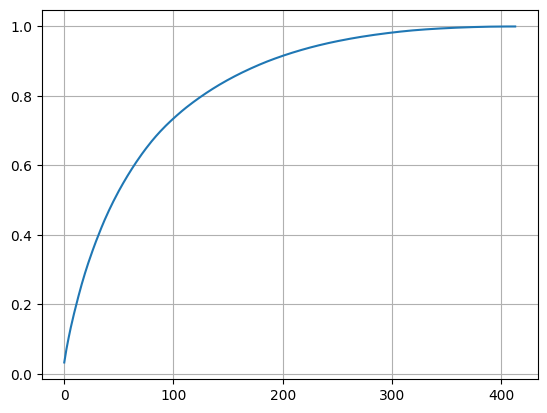

In [40]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.grid()
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

In [41]:
# How much variance we'd capture with the first 125 components
cumulative_explained_variance[300]

0.9824241831916605

In [42]:
pca = PCA(n_components=300)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(item_data_scaled)

# Display shape of PC_items
PC_items.shape

(414, 300)

In [43]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = item_data.index

# Display first 5 rows
items_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,...,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,5.876141,4.828917,-0.495545,3.093849,-0.633706,-11.534092,2.161996,7.116957,5.336009,4.424414,4.637002,2.316503,12.310783,1.986696,-11.431269,5.617791,-2.177268,7.665832,-12.135817,-16.049000,-5.949238,7.814288,40.518194,-35.575039,-17.557418,6.869259,20.886868,2.296657,-26.160394,-32.580135,7.880285,12.358371,6.826718,-32.957865,-4.405057,-17.238628,-11.272274,-14.487767,-2.766330,4.736717,-6.985884,-1.464059,10.603071,1.239909,3.086324,5.336237,-0.410776,1.616712,-6.383660,3.065176,...,-0.024372,-0.427900,-0.250721,-0.031639,0.188748,-0.239297,-0.187888,0.133949,-0.132730,0.206106,0.141760,-0.075818,-0.041833,-0.220161,-0.123058,0.139818,0.106711,0.039477,0.167956,-0.268652,-0.169360,-0.080473,0.079518,-0.051552,-0.006685,-0.023975,-0.030206,0.002716,-0.032774,0.056755,0.145562,-0.013471,0.087733,-0.155619,-0.028600,-0.147210,0.084470,0.082213,0.055668,-0.040864,0.015594,0.113554,-0.045054,-0.071726,-0.158010,-0.049896,-0.043693,0.104261,0.048869,0.002966
12348,-4.219837,1.226217,-1.881912,-0.174340,0.817996,1.160834,-0.871683,-0.846634,0.460240,0.854274,-0.401793,0.981803,-1.104237,0.770190,-0.092975,-0.313393,-0.448633,1.207301,0.381678,-0.469152,0.185789,0.054585,0.499987,0.373514,1.226615,-0.773072,-0.270124,0.850016,-0.370482,-0.573939,1.012802,-0.580828,0.949801,-0.733970,0.353890,-0.387479,-0.298541,0.396417,0.154923,0.333479,-0.466263,0.703452,1.200582,-0.202164,-0.871792,-0.055066,-0.421732,-1.623010,-0.397691,0.452589,...,-0.284357,1.057363,-0.164274,-1.016878,0.692281,1.113369,-0.443947,0.531996,0.677760,0.879970,1.254485,-1.034669,1.361781,-0.275941,0.250866,1.251953,-0.030874,0.599061,-0.164957,-0.025007,0.925016,0.246909,-0.667835,-0.060218,-0.855944,-0.522469,0.938475,0.780648,0.634618,0.066389,-0.581666,-0.632855,0.162518,-0.238778,-0.207739,-0.088156,0.543052,-0.488021,-0.228071,0.183458,0.260432,-0.164639,-0.450247,-0.842608,-0.303910,-1.041709,0.506030,0.750182,1.390973,0.847364
12349,-1.260847,2.387664,-0.073148,-1.119161,-0.034339,-3.715390,-0.343602,-0.149045,-0.790001,-0.379234,1.570091,0.183310,0.223639,-0.051066,3.179090,-0.512679,-1.839577,0.383216,0.317492,-0.003006,-0.420161,0.456437,-0.789675,1.751367,-1.481236,0.757191,-0.912292,0.771947,0.503370,-1.345637,0.286381,0.668565,0.085125,-0.216750,-0.667408,-1.535679,0.783801,-1.418823,-0.098816,-0.929870,0.090829,-0.095242,-0.163215,0.700639,1.381550,-0.243736,-0.105134,-0.176474,0.862919,1.685211,...,0.601660,0.263917,-0.173784,-0.316279,0.962764,-0.313824,0.662921,-0.021673,1.135824,0.514193,-0.189626,-0.331920,0.253425,0.387485,-0.031697,-0.506842,-0.623551,0.516198,0.342797,0.027040,0.216244,-0.296390,0.089390,0.157546,0.024946,0.106762,0.437135,-0.094152,0.430537,-0.252319,0.054333,0.196347,0.146861,-0.552276,0.020485,-0.164206,-0.431147,0.633320,0.369837,0.439575,0.095304,0.019371,0.235854,0.314329,-0.551994,0.353613,-0.148053,-0.733755,0.466710,-0.248120
12350,-4.929320,-0.714859,-1.580930,-0.469767,-0.116290,0.647835,0.112904,-1.336313,1.547069,-1.190409,-0.213170,1.057289,-0.475002,0.856574,-1.305371,0.242700,0.268312,1.952558,-0.227722,0.569825,-0.186512,0.903529,1.364748,0.178125,-0.260397,-0.168825,-0.681952,1.081305,-0.155239,-0.397164,0.240050,0.634067,-1.447082,-0.186098,-0.315379,-0.306429,-1.359019,-0.001474,0.579056,-0.248312,0.588130,-0.217986,0.284602,0.525266,-0.531672,-0.10139

In [44]:
# Save pca_item_data.csv
items_pca.to_csv('pca_item_data.csv')

# KMeans Clustering


In [45]:
# Import analytical base table
base_df = pd.read_csv('analytical_base_table.csv', index_col=0)

# Import thresholded item features
threshold_item_data = pd.read_csv('threshold_item_data.csv', index_col=0)

# Import PCA item features
pca_item_data = pd.read_csv('pca_item_data.csv', index_col=0)

Print the shape of each one to make sure we're on the same page.

In [46]:
# Print shape of each dataframe
print( base_df.shape )
print( threshold_item_data.shape )
print( pca_item_data.shape )

(414, 8)
(414, 120)
(414, 300)


In [47]:
# Join base_df with threshold_item_data
threshold_df = base_df.join(threshold_item_data)

# Display first 5 rows of threshold_df
threshold_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22748,22847,15056BL,23159,85014B,23243,23231,22898,23388,23255,22966,22558,21558,22356,84997C,23292,22699,22331,22385,23480,84375,21156,21242,22417,21122,84997B,22895,22962,22557,22907,23307,20676,21977,21976,23293,22661,23290,22627,84879,20682,22367,23236,...,22631,22090,23199,21915,23203,84997D,22029,23209,23254,22077,22960,23256,22492,22467,22726,22382,23240,23245,21094,21086,23206,22352,22727,22138,22720,21559,22728,22555,20724,20712,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,2,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,5,0,0,0,3,0,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


In [48]:
# Join base_df with pca_item_data
pca_df = base_df.join(pca_item_data)

# Display first 5 rows of pca_df
pca_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,...,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.876141,4.828917,-0.495545,3.093849,-0.633706,-11.534092,2.161996,7.116957,5.336009,4.424414,4.637002,2.316503,12.310783,1.986696,-11.431269,5.617791,-2.177268,7.665832,-12.135817,-16.049000,-5.949238,7.814288,40.518194,-35.575039,-17.557418,6.869259,20.886868,2.296657,-26.160394,-32.580135,7.880285,12.358371,6.826718,-32.957865,-4.405057,-17.238628,-11.272274,-14.487767,-2.766330,4.736717,-6.985884,-1.464059,...,-0.024372,-0.427900,-0.250721,-0.031639,0.188748,-0.239297,-0.187888,0.133949,-0.132730,0.206106,0.141760,-0.075818,-0.041833,-0.220161,-0.123058,0.139818,0.106711,0.039477,0.167956,-0.268652,-0.169360,-0.080473,0.079518,-0.051552,-0.006685,-0.023975,-0.030206,0.002716,-0.032774,0.056755,0.145562,-0.013471,0.087733,-0.155619,-0.028600,-0.147210,0.084470,0.082213,0.055668,-0.040864,0.015594,0.113554,-0.045054,-0.071726,-0.158010,-0.049896,-0.043693,0.104261,0.048869,0.002966
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.219837,1.226217,-1.881912,-0.174340,0.817996,1.160834,-0.871683,-0.846634,0.460240,0.854274,-0.401793,0.981803,-1.104237,0.770190,-0.092975,-0.313393,-0.448633,1.207301,0.381678,-0.469152,0.185789,0.054585,0.499987,0.373514,1.226615,-0.773072,-0.270124,0.850016,-0.370482,-0.573939,1.012802,-0.580828,0.949801,-0.733970,0.353890,-0.387479,-0.298541,0.396417,0.154923,0.333479,-0.466263,0.703452,...,-0.284357,1.057363,-0.164274,-1.016878,0.692281,1.113369,-0.443947,0.531996,0.677760,0.879970,1.254485,-1.034669,1.361781,-0.275941,0.250866,1.251953,-0.030874,0.599061,-0.164957,-0.025007,0.925016,0.246909,-0.667835,-0.060218,-0.855944,-0.522469,0.938475,0.780648,0.634618,0.066389,-0.581666,-0.632855,0.162518,-0.238778,-0.207739,-0.088156,0.543052,-0.488021,-0.228071,0.183458,0.260432,-0.164639,-0.450247,-0.842608,-0.303910,-1.041709,0.506030,0.750182,1.390973,0.847364
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.260847,2.387664,-0.073148,-1.119161,-0.034339,-3.715390,-0.343602,-0.149045,-0.790001,-0.379234,1.570091,0.183310,0.223639,-0.051066,3.179090,-0.512679,-1.839577,0.383216,0.317492,-0.003006,-0.420161,0.456437,-0.789675,1.751367,-1.481236,0.757191,-0.912292,0.771947,0.503370,-1.345637,0.286381,0.668565,0.085125,-0.216750,-0.667408,-1.535679,0.783801,-1.418823,-0.098816,-0.929870,0.090829,-0.095242,...,0.601660,0.263917,-0.173784,-0.316279,0.962764,-0.313824,0.662921,-0.021673,1.135824,0.514193,-0.189626,-0.331920,0.253425,0.387485,-0.031697,-0.506842,-0.623551,0.516198,0.342797,0.027040,0.216244,-0.296390,0.089390,0.157546,0.024946,0.106762,0.437135,-0.094152,0.430537,-0.252319,0.054333,0.196347,0.146861,-0.552276,0.020485,-0.164206,-0.431147,0.633320,0.369837,0.439575,0.095304,0.019371,0.235854,0.314329,-0.551994,0.353613,-0.148053,-0.733755,0.466710,-0.248120
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.929320,-0.714859,-1.580930,-0.469767,-0.116290,0.647835,0.112904,-1.336313,1.547069,-1.190409,-0.213170,1.057289,-0.475002,0.856574,-1.305371,0.242700,0.268312,1.952558,-0.227722,0.569825,-0.186512,0.903529,1.364748,0.178125,-0.260397,-0.168825,-0.681952,1.081305,-0.155239,-0.397164,0.240050,0.634067,-1.447082,-0.186098,-0.315379,-0.306429,-1.359019,-0.001474,0.5

In [49]:
# Initialize instance of StandardScaler
t_scaler = StandardScaler()
p_scaler = StandardScaler()

# Fit and transform
threshold_df_scaled = t_scaler.fit_transform(threshold_df)
pca_df_scaled = p_scaler.fit_transform(pca_df)

K-Means with threshold_df

In [50]:
t_kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 123)

In [51]:
t_kmeans.fit(threshold_df_scaled)
threshold_df['cluster'] = t_kmeans.fit_predict(threshold_df_scaled)

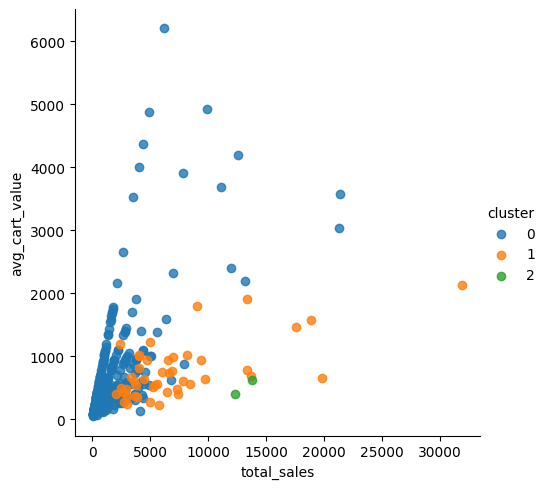

In [52]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=threshold_df, fit_reg=False)

K-Means with pca_df

In [53]:
p_kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 123)

In [54]:
p_kmeans.fit(pca_df_scaled)
pca_df['cluster'] = p_kmeans.fit_predict(pca_df_scaled)

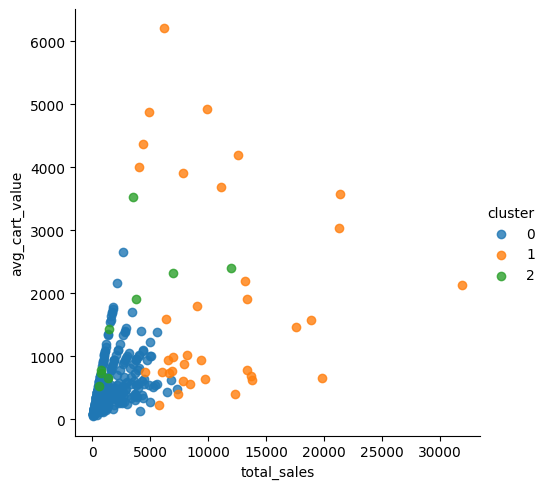

In [55]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=pca_df, fit_reg=False)

In [56]:
# Similary between base_df.cluster and threshold_df.cluster
adjusted_rand_score(pca_df.cluster, threshold_df.cluster)

0.36184888003997073